# CAISO-IRP23 Network Analysis & Visualization

This notebook performs comprehensive analysis and visualization of the solved CAISO IRP 2023 energy system model.

## Analysis Overview

This notebook will analyze:
1. **Energy Balance** - Supply and demand patterns
2. **Generation Capacity** - Optimal capacity by technology
3. **Capacity Factors** - Generator utilization rates
4. **Economic Analysis** - Capital and operational costs
5. **Comprehensive Dashboard** - Multi-metric overview

All visualizations use **Tableau 10 color palette** for professional, publication-ready figures.

---

## Setup and Configuration

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pypsa

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))

from plexos_to_pypsa_converter.analysis import NetworkAnalyzer
from plexos_to_pypsa_converter.analysis.styles import apply_default_style

# Apply default styling
apply_default_style()

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 150
plt.rcParams["figure.figsize"] = (10, 6)

print("✓ Imports and configuration complete")

✓ Imports and configuration complete


## Load Solved Network

Load the network file created by `caiso_solve.ipynb`:

In [ ]:
# Define path to solved network
network_file = Path.cwd().parent / "results" / "caiso-irp23" / "solved_network_1year.nc"

if not network_file.exists():
    msg = "Network file not found: " + str(network_file)
    # Run the solver notebook to generate the solved network file.
    raise FileNotFoundError(msg)

# Load network
print(f"Loading network from: {network_file.name}")
network = pypsa.Network()
network.import_from_netcdf(str(network_file))

print("✓ Network loaded successfully")
print(f"  File size: {network_file.stat().st_size / 1024 / 1024:.2f} MB")

Loading network from: solved_network_1year.nc


/Users/meas/env/plexos-xml/lib/python3.11/site-packages/dask/array/einsumfuncs.py:2: DeprecationWarning:

`np.compat`, which was used during the Python 2 to 3 transition, is deprecated since 1.26.0, and will be removed

INFO:pypsa.io:Imported network solved_network_1year.nc has buses, carriers, generators, links, loads


✓ Network loaded successfully
  File size: 174.64 MB


## Initialize Network Analyzer

Create the `NetworkAnalyzer` with **Tableau 10 color palette** for consistent, professional visualizations:

In [ ]:
# Initialize analyzer with Tableau colors
analyzer = NetworkAnalyzer(
    network, exclude_slack_default=True, color_palette="tableau10"
)

print("✓ NetworkAnalyzer initialized with Tableau 10 color palette")
print(f"  Spatial resolution: {analyzer.spatial_resolution}")
print(f"  Multi-period: {analyzer.multi_period}")
print(f"  Slack generators: {len(analyzer.slack_generators)}")

✓ NetworkAnalyzer initialized with Tableau 10 color palette
  Spatial resolution: zonal
  Multi-period: False
  Slack generators: 16


---

# Network Overview

## Network Statistics

Display key statistics about the network structure:

In [ ]:
# Get network info
info = analyzer.info()

print("=" * 70)
print(" CAISO-IRP23 Network Statistics")
print("=" * 70)
print()
print(f"Buses:              {info['buses']:>6}")
print(f"Generators:         {info['generators']:>6}")
print(f"Loads:              {info['loads']:>6}")
print(f"Links:              {info['links']:>6}")
print(f"Storage Units:      {info['storage_units']:>6}")
print(f"Stores:             {info['stores']:>6}")
print()
print(f"Snapshots:          {info['snapshots']:>6}")

# Display investment periods (0 or N/A for single-period models)
inv_periods = info["investment_periods"]
if inv_periods > 0:
    print(f"Investment Periods: {inv_periods:>6}")
else:
    print(f"Investment Periods: {'N/A':>6}")

print(f"Carriers:           {info['carriers']:>6}")
print(f"Bus Carriers:       {len(info['bus_carriers']):>6}")
print()
print(f"Spatial Resolution: {info['spatial_resolution']}")
print(f"Multi-period:       {info['multi_period']}")
print()
print(f"Has Time Series:    {info['has_time_series']}")
print(f"Has Storage:        {info['has_storage']}")
print(f"Has Stores:         {info['has_stores']}")
print(f"Has Links:          {info['has_links']}")
print()
print("=" * 70)

 CAISO-IRP23 Network Statistics

Buses:                   8
Generators:            959
Loads:                   5
Links:                  16
Storage Units:           0
Stores:                  0

Snapshots:            8760
Investment Periods:    N/A
Carriers:               33
Bus Carriers:            1

Spatial Resolution: zonal
Multi-period:       False

Has Time Series:    True
Has Storage:        False
Has Stores:         False
Has Links:          True



## Generator Carriers

List all energy carriers (technologies) in the model:

In [ ]:
# Display carriers
carriers = sorted(network.generators.carrier.unique())
print(f"Total unique carriers: {len(carriers)}\n")

# Create a formatted list
for i, carrier in enumerate(carriers, 1):
    if i % 3 == 1:
        print(f"  {i:2d}. {carrier:30s}", end="")
    elif i % 3 == 0:
        print(f"  {i:2d}. {carrier}")
    else:
        print(f"  {i:2d}. {carrier:30s}", end="")
if len(carriers) % 3 != 0:
    print()

Total unique carriers: 29

   1.                                  2. Bio_Agri_Res                     3. Bio_Landfill_Gas_CA
   4. Bio_Other_CA                     5. Bio_Sludge_Waste_CA              6. Bio_Solid_Waste_CA
   7. Bio_Wood_CA                      8. Coal_CA_South                    9. DR - High
  10. DR - Mid                        11. Dummy                           12. Geothermal_CA
  13. NG_AZ_North                     14. NG_AZ_North-South               15. NG_Baja
  16. NG_Baja_CA                      17. NG_CA PGaE BB                   18. NG_CA PGaE LT
  19. NG_CA SDGE                      20. NG_CA SJ Valley                 21. NG_CA SoCalB
  22. NG_CA SoCalGas                  23. NG_Nevada_South                 24. Oil_DistillateFuel_2_CA
  25. Petroleum Coke_CA               26. Uranium                         27. hydro
  28. load shedding                   29. load spillage                 


---

# Energy Balance Analysis

## Understanding Energy Balance

Energy balance shows the **supply** (positive) and **withdrawal** (negative) of energy by carrier:
- **Supply**: Energy generated or supplied to the system (generators, imports)
- **Withdrawal**: Energy consumed or withdrawn from the system (loads, exports, losses)

This analysis helps us understand:
- Which technologies provide the most energy
- How energy is consumed across the system
- The overall energy mix

## Figure 1: Total Energy Balance by Carrier

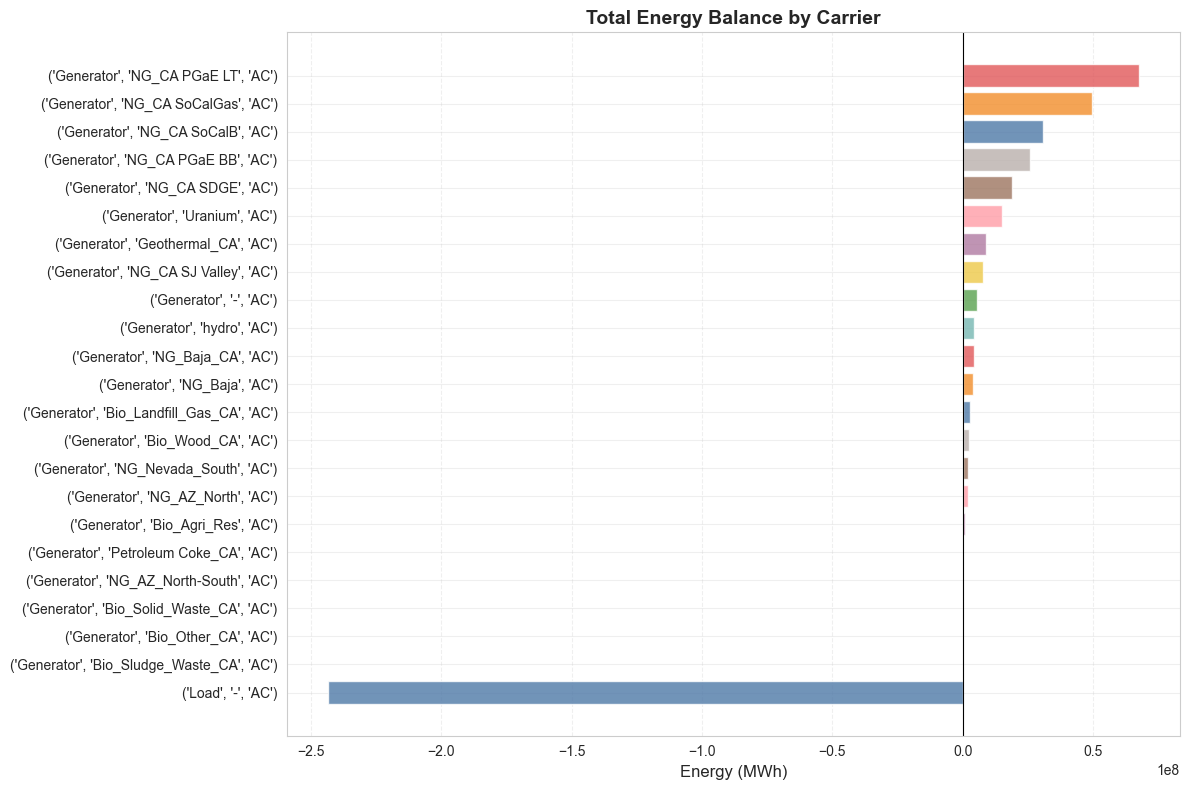

Figure 1: Total energy balance showing supply (right) and withdrawal (left) by carrier.
Colors: Tableau 10 palette


In [ ]:
# Create energy balance plot
fig, ax = plt.subplots(figsize=(12, 8))
analyzer.plot_energy_balance_totals(ax=ax)
plt.tight_layout()
plt.show()

print(
    "Figure 1: Total energy balance showing supply (right) and withdrawal (left) by carrier."
)
print("Colors: Tableau 10 palette")

### Energy Balance Metrics

Extract key energy metrics:

In [ ]:
# Get supply and withdrawal data
supply = analyzer.get_supply()
withdrawal = analyzer.get_withdrawal()

print("Top 5 Energy Suppliers:")
print("=" * 50)
for carrier, value in supply.head(5).items():
    carrier_str = str(carrier) if not isinstance(carrier, str) else carrier
    print(f"  {carrier_str:30s} {value:>15,.0f} MWh")

print("\nTop 5 Energy Withdrawals:")
print("=" * 50)
for carrier, value in withdrawal.head(5).items():
    carrier_str = str(carrier) if not isinstance(carrier, str) else carrier
    print(f"  {carrier_str:30s} {value:>15,.0f} MWh")

print(f"\nTotal Supply:    {supply.sum():>15,.0f} MWh")
print(f"Total Withdrawal: {abs(withdrawal.sum()):>15,.0f} MWh")

Top 5 Energy Suppliers:
  ('Link', 'AC')                     130,056,571 MWh
  ('Generator', '-')                   5,315,526 MWh
  ('Generator', 'Bio_Agri_Res')          717,970 MWh
  ('Generator', 'Bio_Landfill_Gas_CA')       2,696,815 MWh
  ('Generator', 'Bio_Other_CA')           26,893 MWh

Top 5 Energy Withdrawals:
  ('Load', '-')                      243,486,323 MWh
  ('Link', 'AC')                     130,056,571 MWh
  ('Generator', 'Load spillage')     252,688,572 MWh

Total Supply:        382,811,350 MWh
Total Withdrawal:     626,231,466 MWh


---

# Generation Capacity Analysis

## Understanding Capacity

**Optimal Capacity** represents the installed generation capacity (in MW) for each technology. This shows:
- The mix of generation technologies
- Relative size of each technology's capacity
- Investment decisions in the model

## Figure 2: Optimal Capacity by Carrier

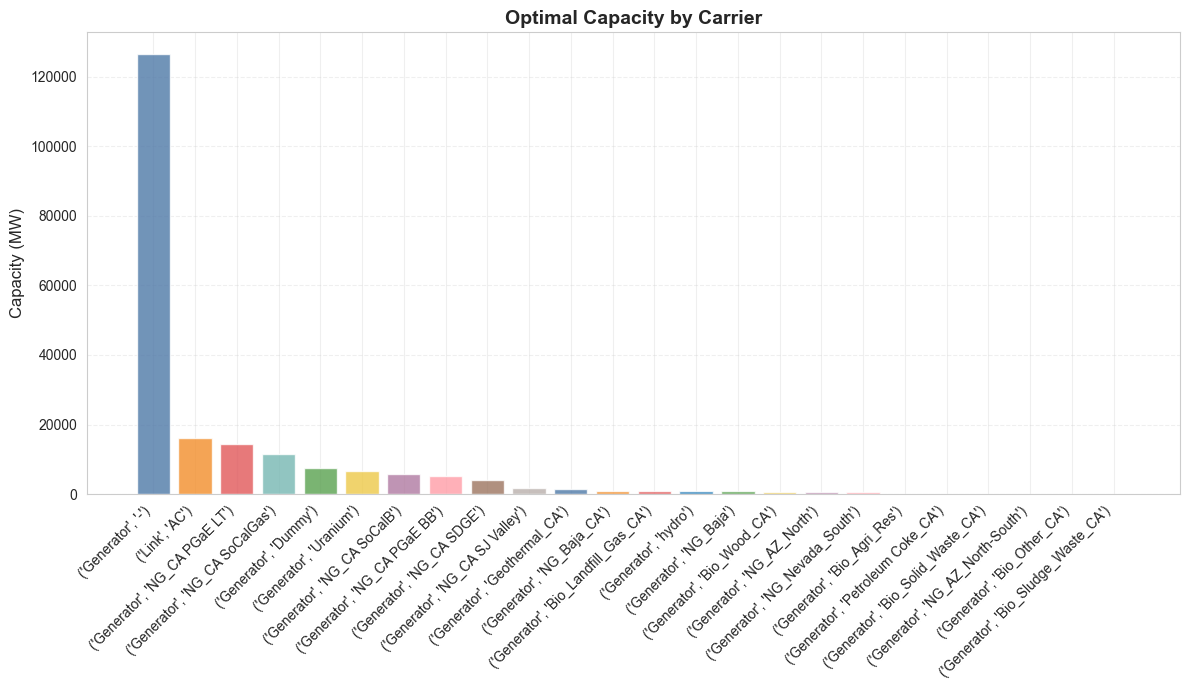

Figure 2: Optimal generation capacity by carrier (MW).
Shows the installed capacity for each technology type.


In [ ]:
# Create capacity overview plot
fig, ax = plt.subplots(figsize=(12, 7))
analyzer.plot_capacity_overview(capacity_type="optimal", groupby="carrier", ax=ax)
plt.tight_layout()
plt.show()

print("Figure 2: Optimal generation capacity by carrier (MW).")
print("Shows the installed capacity for each technology type.")

### Capacity Metrics

In [ ]:
# Get capacity data
capacity = analyzer.get_optimal_capacity()
total_capacity = capacity.sum()

print("Top 10 Technologies by Capacity:")
print("=" * 70)
print(f"{'Carrier':<30s} {'Capacity (MW)':>15s} {'Share':>10s}")
print("=" * 70)

for carrier, cap in capacity.head(10).items():
    carrier_str = str(carrier) if not isinstance(carrier, str) else carrier
    share = cap / total_capacity * 100
    print(f"{carrier_str:<30s} {cap:>15,.0f} {share:>9.1f}%")

print("=" * 70)
print(f"{'TOTAL':<30s} {total_capacity:>15,.0f} {100.0:>9.1f}%")
print("=" * 70)

Top 10 Technologies by Capacity:
Carrier                          Capacity (MW)      Share
('Link', 'AC')                          16,000       7.8%
('Generator', '-')                     126,506      61.4%
('Generator', 'Bio_Agri_Res')              111       0.1%
('Generator', 'Bio_Landfill_Gas_CA')             949       0.5%
('Generator', 'Bio_Other_CA')               10       0.0%
('Generator', 'Bio_Sludge_Waste_CA')               7       0.0%
('Generator', 'Bio_Solid_Waste_CA')              55       0.0%
('Generator', 'Bio_Wood_CA')               667       0.3%
('Generator', 'Dummy')                   7,534       3.7%
('Generator', 'Geothermal_CA')           1,391       0.7%
TOTAL                                  206,145     100.0%


## Capacity Factors

**Capacity Factor** measures how much a generator is actually used relative to its maximum capacity:
- **1.0 (100%)**: Generator runs at full capacity continuously
- **0.5 (50%)**: Generator operates at half capacity on average
- **Low values**: Intermittent sources (solar, wind) or peaking plants
- **High values**: Baseload plants (nuclear, coal) or must-run facilities

## Figure 3: Capacity Factors by Carrier

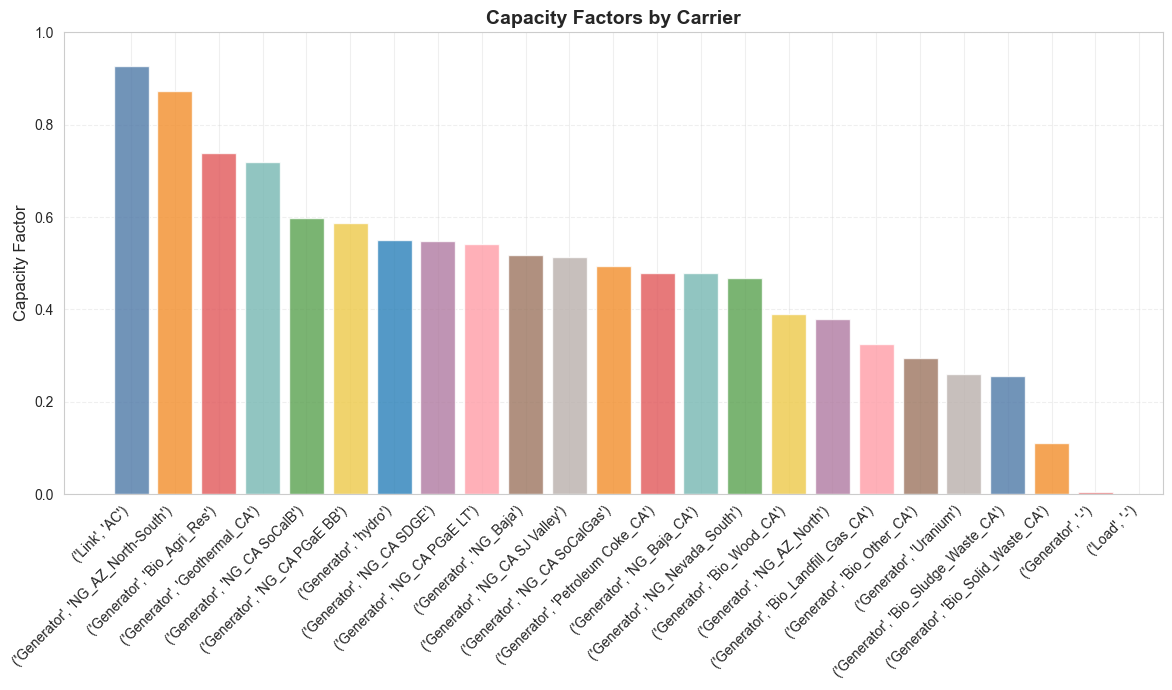

Figure 3: Capacity factors by carrier (utilization rate, 0-1).
Higher values indicate more consistent operation.


In [ ]:
# Create capacity factors plot
fig, ax = plt.subplots(figsize=(12, 7))
analyzer.plot_capacity_factors(groupby="carrier", ax=ax)
plt.tight_layout()
plt.show()

print("Figure 3: Capacity factors by carrier (utilization rate, 0-1).")
print("Higher values indicate more consistent operation.")

### Capacity Factor Analysis

In [ ]:
# Get capacity factor data
cf = analyzer.get_capacity_factors()

print("Capacity Factors by Technology:")
print("=" * 60)
print(f"{'Carrier':<30s} {'Capacity Factor':>15s} {'Utilization':>10s}")
print("=" * 60)

for carrier, factor in cf.head(15).items():
    carrier_str = str(carrier) if not isinstance(carrier, str) else carrier
    print(f"{carrier_str:<30s} {factor:>15.3f} {factor * 100:>9.1f}%")

print("=" * 60)

# Summary statistics
print(f"\nMean Capacity Factor: {cf.mean():.3f} ({cf.mean() * 100:.1f}%)")
print(f"Median Capacity Factor: {cf.median():.3f} ({cf.median() * 100:.1f}%)")

Capacity Factors by Technology:
Carrier                        Capacity Factor Utilization
('Load', '-')                              nan       nan%
('Link', 'AC')                           0.928      92.8%
('Generator', '-')                       0.005       0.5%
('Generator', 'Bio_Agri_Res')            0.738      73.8%
('Generator', 'Bio_Landfill_Gas_CA')           0.324      32.4%
('Generator', 'Bio_Other_CA')            0.295      29.5%
('Generator', 'Bio_Sludge_Waste_CA')           0.256      25.6%
('Generator', 'Bio_Solid_Waste_CA')           0.111      11.1%
('Generator', 'Bio_Wood_CA')             0.390      39.0%
('Generator', 'Geothermal_CA')           0.719      71.9%
('Generator', 'NG_AZ_North')             0.379      37.9%
('Generator', 'NG_AZ_North-South')           0.874      87.4%
('Generator', 'NG_Baja')                 0.518      51.8%
('Generator', 'NG_Baja_CA')              0.478      47.8%
('Generator', 'NG_CA PGaE BB')           0.586      58.6%

Mean Capacity Fac

---

# Economic Analysis

## Understanding Costs

The model tracks two types of costs:
- **CAPEX (Capital Expenditure)**: Upfront investment costs for building capacity
- **OPEX (Operational Expenditure)**: Ongoing costs for fuel, maintenance, and operation

This analysis shows:
- Which technologies have high capital vs. operating costs
- The economic trade-offs between technologies
- Total system costs

## Figure 4: Cost Breakdown (CAPEX + OPEX)

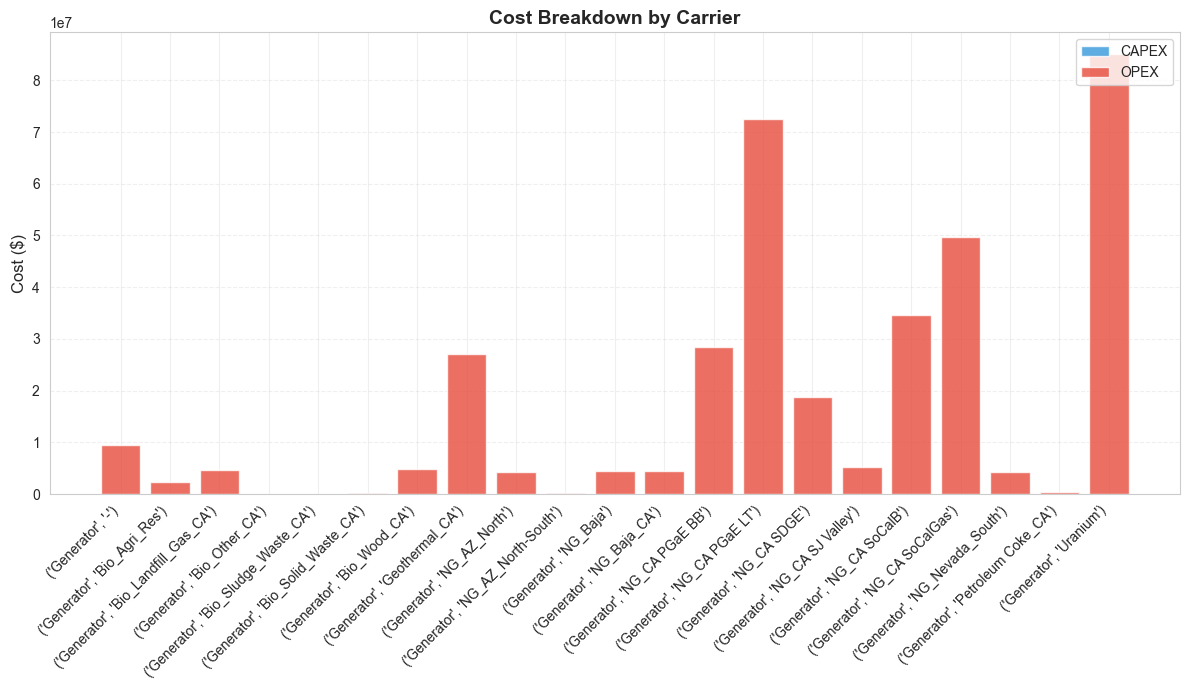

Figure 4: Cost breakdown showing CAPEX (blue) and OPEX (red) by carrier.
Total height represents total cost per technology.


In [ ]:
# Create cost breakdown plot
fig, ax = plt.subplots(figsize=(12, 7))
analyzer.plot_cost_breakdown(groupby="carrier", ax=ax)
plt.tight_layout()
plt.show()

print("Figure 4: Cost breakdown showing CAPEX (blue) and OPEX (red) by carrier.")
print("Total height represents total cost per technology.")

## Figure 5: CAPEX vs OPEX Comparison

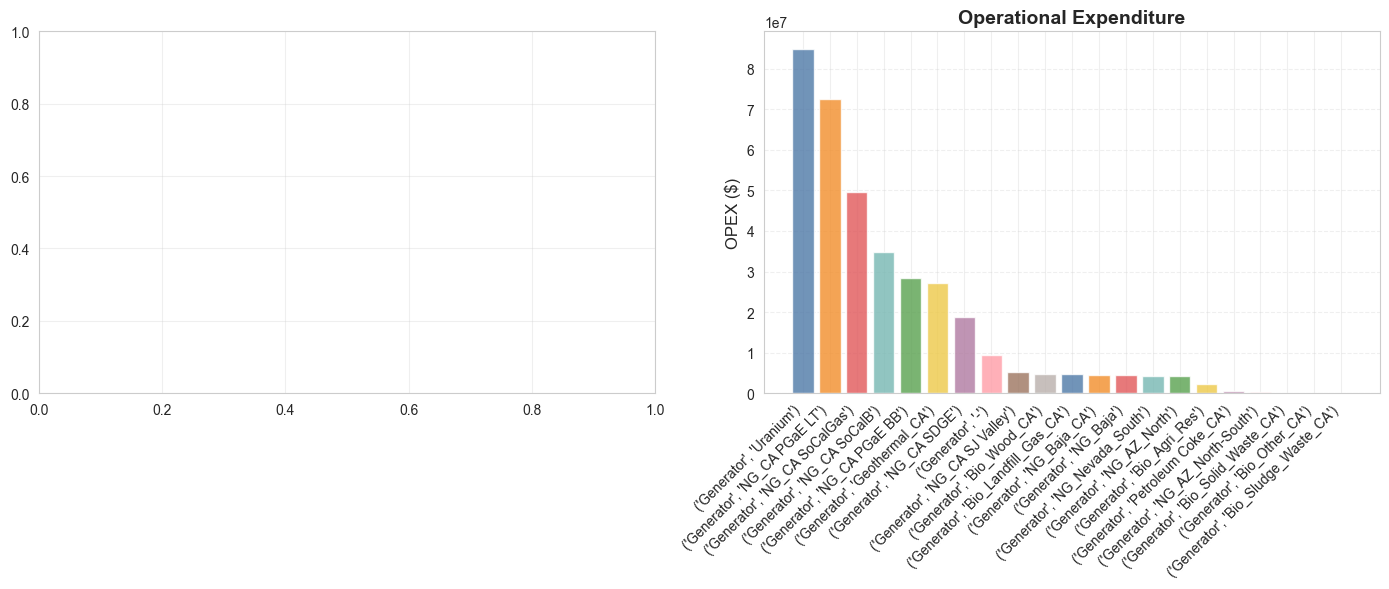

Figure 5: Side-by-side comparison of CAPEX and OPEX by carrier.
Left: Capital costs | Right: Operating costs
Note that the CAISO-IRP23 model has no discovered costs such as Build Costs for generators, hence why CAPEX is empty.


In [ ]:
# Create cost comparison plot
fig, axes = analyzer.plot_cost_comparison(groupby="carrier", figsize=(14, 6))
plt.tight_layout()
plt.show()

print("Figure 5: Side-by-side comparison of CAPEX and OPEX by carrier.")
print("Left: Capital costs | Right: Operating costs")
print(
    "Note that the CAISO-IRP23 model has no discovered costs such as Build Costs for generators, hence why CAPEX is empty."
)

---

# Comprehensive Dashboard

## Multi-Metric Overview

This dashboard combines the key metrics from all previous analyses into a single view:
- **Top Left**: Energy balance totals
- **Top Right**: Optimal capacity by carrier
- **Bottom Left**: Cost breakdown (CAPEX + OPEX)
- **Bottom Right**: Capacity factors

All plots use consistent **Tableau 10 colors** for easy comparison across metrics.

## Figure 6: Network Analysis Dashboard

/var/folders/rc/7zk_g8g92bg3cj2jm646csv00000gn/T/ipykernel_18796/1226621157.py:3: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



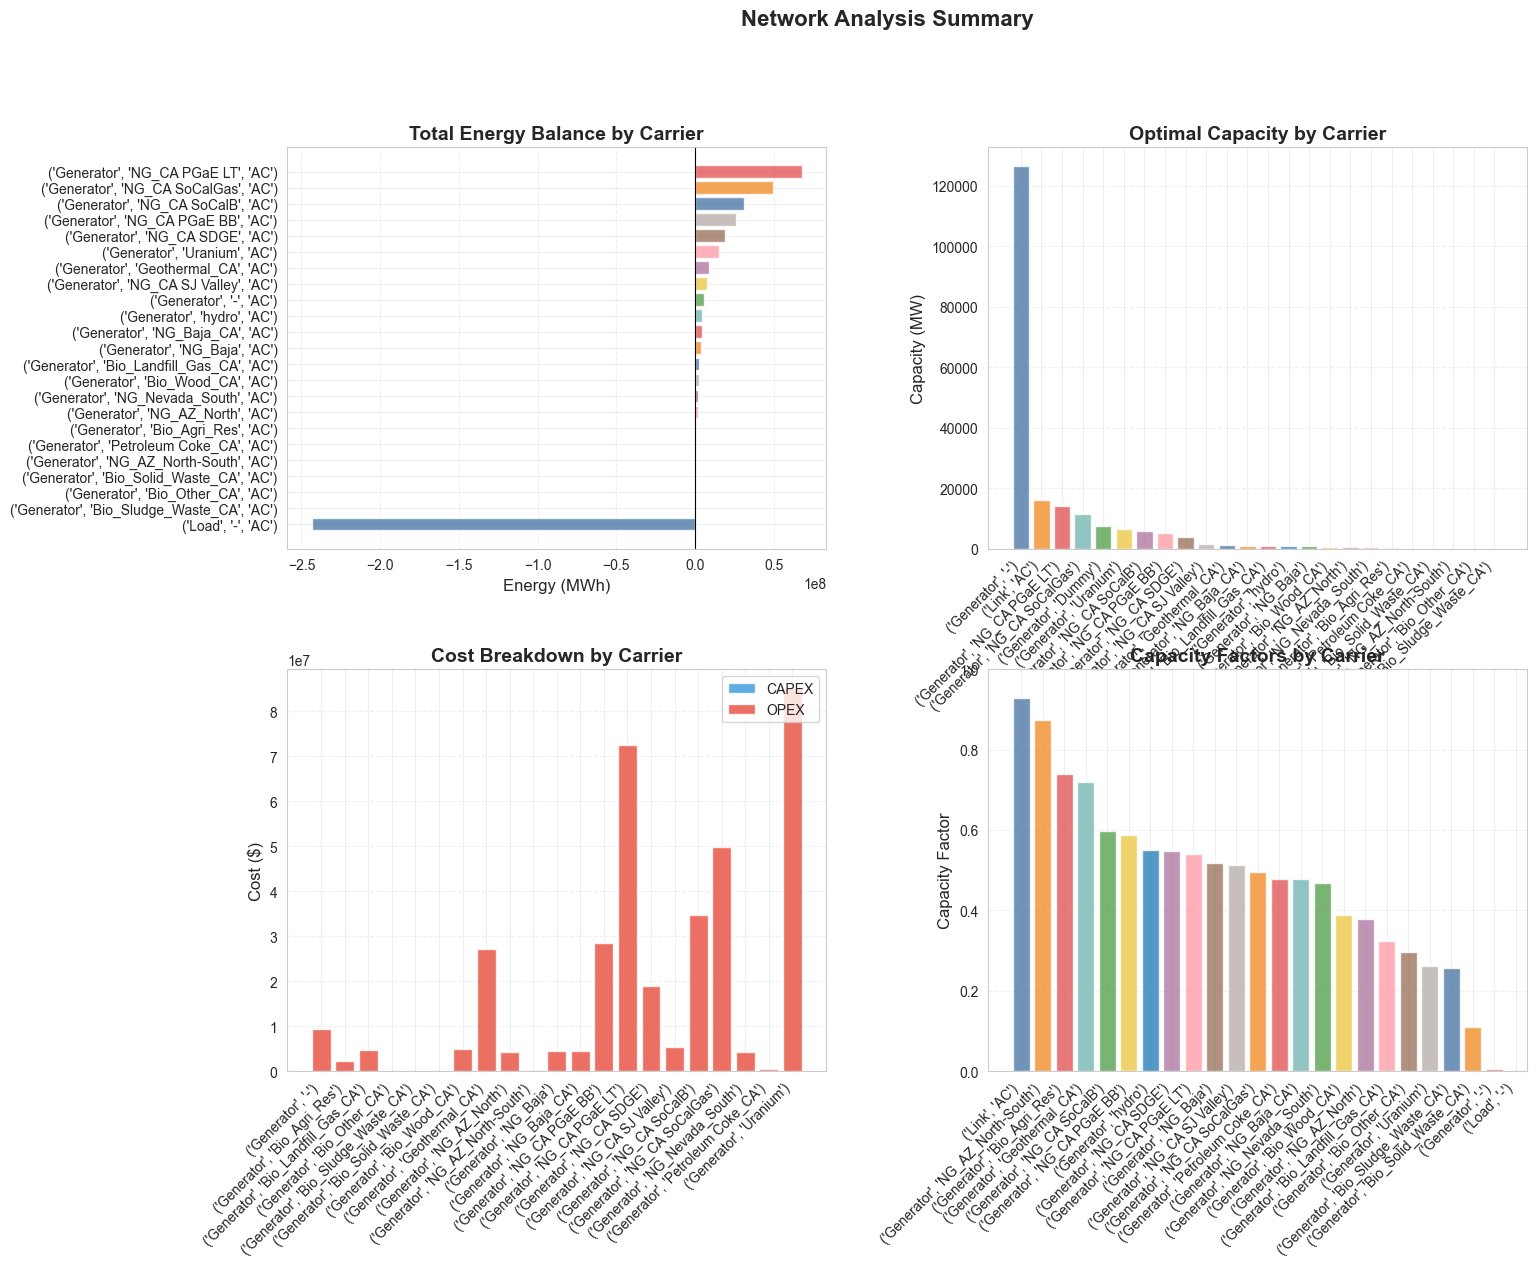

Figure 6: Comprehensive dashboard with all key metrics.
All plots use consistent Tableau 10 color palette.


In [ ]:
# Create comprehensive dashboard
fig = analyzer.create_dashboard(figsize=(16, 12))
plt.tight_layout()
plt.show()

print("Figure 6: Comprehensive dashboard with all key metrics.")
print("All plots use consistent Tableau 10 color palette.")

---

# Key Findings & Summary

## Summary Statistics Table

In [ ]:
# Create summary statistics DataFrame
summary_data = {
    "Metric": [
        "Total Capacity",
        "Total Energy Supply",
        "Total Energy Withdrawal",
        "Mean Capacity Factor",
        "Total CAPEX",
        "Total OPEX",
        "Total System Cost",
        "Number of Generators",
        "Number of Carriers",
        "Number of Snapshots",
    ],
    "Value": [
        f"{capacity.sum():,.0f} MW",
        f"{supply.sum():,.0f} MWh",
        f"{abs(withdrawal.sum()):,.0f} MWh",
        f"{cf.mean():.3f} ({cf.mean() * 100:.1f}%)",
        f"${capex.sum():,.0f}",
        f"${opex.sum():,.0f}",
        f"${total.sum():,.0f}",
        f"{len(network.generators)}",
        f"{len(carriers)}",
        f"{len(network.snapshots)}",
    ],
}

summary_df = pd.DataFrame(summary_data)
print("=" * 70)
print(" CAISO-IRP23 Model Summary")
print("=" * 70)
print()
print(summary_df.to_string(index=False))
print()
print("=" * 70)

 CAISO-IRP23 Model Summary

                 Metric           Value
         Total Capacity      206,145 MW
    Total Energy Supply 382,811,350 MWh
Total Energy Withdrawal 626,231,466 MWh
   Mean Capacity Factor   0.481 (48.1%)
            Total CAPEX              $0
             Total OPEX    $360,985,184
      Total System Cost              $0
   Number of Generators             959
     Number of Carriers              29
    Number of Snapshots            8760



## Export Figures

Optionally save all figures to files for reports or presentations:

In [ ]:
# Uncomment to save figures
# output_dir = Path("figures")
# output_dir.mkdir(exist_ok=True)

# print("Saving figures...")
# analyzer.plot_energy_balance_totals(save_path=output_dir / "energy_balance.png", dpi=300)
# analyzer.plot_capacity_overview(save_path=output_dir / "capacity.png", dpi=300)
# analyzer.plot_capacity_factors(save_path=output_dir / "capacity_factors.png", dpi=300)
# analyzer.plot_cost_breakdown(save_path=output_dir / "costs.png", dpi=300)
# analyzer.create_dashboard(save_path=output_dir / "dashboard.png", dpi=300)
# print(f"✓ Figures saved to {output_dir}/")

print("To save figures, uncomment the code above and run this cell.")

---

## Analysis Complete

✓ All visualizations generated with **Tableau 10 color palette**

✓ Comprehensive analysis of energy, capacity, and economic metrics

✓ Key findings summarized above

### Next Steps

You can:
1. Modify the analysis by changing parameters in the cells above
2. Export figures for reports (uncomment export section)
3. Compare with other scenarios by loading different network files
4. Dive deeper into specific carriers or time periods

---